In [131]:
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax

import e3nn_jax as e3nn

jnp.set_printoptions(precision=3, suppress=True)

In [152]:
@partial(jax.jit, static_argnums=(1,))
def forward(R, lmax: int):
    assert R.ndim == 2
    assert R.irreps == "1o"
    return e3nn.sum(e3nn.spherical_harmonics(range(lmax + 1), R, True), axis=0)


@partial(jax.jit, static_argnums=(2, 3, 6, 7))
def inverse(
    Y,
    rng,
    n: int,
    steps: int = 1000,
    lr: float = 0.1,
    init_amplitude: float = 0.01,
    decay_rate: float = 0.5,
    num_decays: int = 4,
):
    lmax = Y.irreps.lmax
    assert Y.ndim == 1
    assert Y.irreps == e3nn.Irreps.spherical_harmonics(lmax)

    def loss(R):
        Y_ = e3nn.sum(e3nn.spherical_harmonics(range(lmax + 1), R, False), axis=0)
        return jnp.sum((Y - Y_).array ** 2)

    scheduler = optax.exponential_decay(
        init_value=lr, transition_steps=steps, decay_rate=decay_rate
    )
    opt = optax.chain(
        optax.scale_by_adam(),
        optax.scale_by_schedule(scheduler),
        optax.scale(-1.0),
    )

    def update(i, x):
        R, opt_state, values = x
        value, grads = jax.value_and_grad(loss)(R)
        updates, opt_state = opt.update(grads, opt_state)
        R = optax.apply_updates(R, updates)
        return R, opt_state, values.at[i].set(value)

    R = init_amplitude * e3nn.IrrepsArray("1o", jax.random.normal(rng, (n, 3)))
    opt_state = opt.init(R)
    values = jnp.zeros(num_decays * steps)
    R, opt_state, values = jax.lax.fori_loop(
        0, len(values), update, (R, opt_state, values)
    )

    return R, values

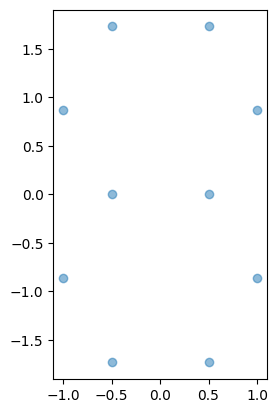

In [183]:
R1 = e3nn.IrrepsArray(
    "1o",
    jnp.array(
        [
            [jnp.cos(phi), 0.0, jnp.sin(phi) - jnp.sin(jnp.pi / 3)]
            for phi in jnp.linspace(0, 2 * jnp.pi, 6, endpoint=False)
        ]
        + [
            [jnp.cos(phi), 0.0, jnp.sin(phi) + jnp.sin(jnp.pi / 3)]
            for phi in jnp.linspace(0, 2 * jnp.pi, 6, endpoint=False)[:-2]
        ]
        # + [[0.0, 1.0, 0.0]]
    ),
)

plt.plot(
    R1.array[:, 0], R1.array[:, 2], "o", label="original", color="tab:blue", alpha=0.5
)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

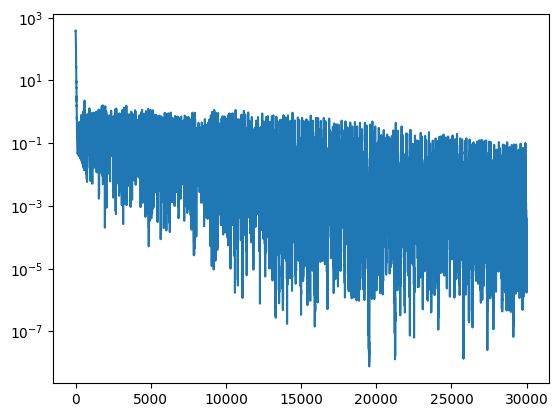

In [185]:
Y1 = forward(R1, 6)
R2, loss = inverse(
    Y1,
    jax.random.PRNGKey(2),
    len(R1),
    steps=10_000,
    lr=0.1,
    init_amplitude=0.001,
    decay_rate=0.5,
    num_decays=3,
)
Y2 = forward(R2, 6)

plt.plot(loss)
plt.yscale("log")

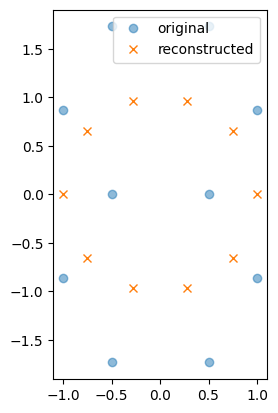

In [186]:
plt.plot(
    R1.array[:, 0], R1.array[:, 2], "o", label="original", color="tab:blue", alpha=0.5
)
plt.plot(
    R2.array[:, 0], R2.array[:, 2], "x", label="reconstructed", color="tab:orange"
)
plt.legend()
# square plot
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

In [187]:
Y1

1x0e+1x1o+1x2e+1x3o+1x4e+1x5o+1x6e
[ 10.     -0.      0.     -0.      0.      0.    -11.18    0.      1.575
  -0.      0.      0.      0.      0.      0.     -0.      0.      0.
   0.      0.     11.25    0.     -1.364   0.     -0.242   0.      0.
   0.      0.     -0.      0.      0.      0.      0.      0.     -0.
   0.      0.     -0.      0.     -0.      0.    -11.267   0.      1.328
   0.      0.195   0.     -1.92 ]

In [188]:
Y2

1x0e+1x1o+1x2e+1x3o+1x4e+1x5o+1x6e
[ 10.      0.     -0.     -0.      0.     -0.    -11.18    0.      1.575
   0.      0.     -0.      0.      0.      0.      0.     -0.001  -0.
  -0.      0.     11.25   -0.     -1.364  -0.     -0.242   0.     -0.
  -0.     -0.      0.     -0.     -0.     -0.     -0.      0.     -0.
   0.001   0.      0.001   0.      0.     -0.    -11.267   0.001   1.328
   0.      0.195  -0.     -1.921]